#### LSTM 

In this context, a Long Short-Term Memory (LSTM) network is a specialized type of recurrent neural network (RNN) designed to capture and learn long-range dependencies and temporal patterns in sequential financial data, such as asset prices, returns, and technical indicators. Unlike traditional feedforward networks, LSTMs have memory cells and gating mechanisms that allow them to retain information across many time steps, making them particularly effective for modeling the dynamics of financial markets and predicting future trends.

When used for portfolio optimization, the LSTM receives as input a sequence of features (such as those transformed by PCA) over a lookback window for each asset. The network processes this temporal information to generate a vector of portfolio weights, dynamically adjusting allocations in response to evolving market conditions. This approach enables the model to learn complex, non-linear relationships between historical market behavior and optimal asset allocation, potentially outperforming static or linear strategies.

By leveraging LSTM architectures, we can achieve:

Dynamic portfolio allocation that adapts to changing market patterns.

Improved risk-adjusted returns, as the model can learn to anticipate and respond to market volatility and regime shifts.

Automation of investment decisions, reducing the influence of human bias and emotion.

Comprehensive evaluation, including metrics such as cumulative returns, volatility, Sharpe ratio, and maximum drawdown, to assess the effectiveness of the LSTM-based strategy compared to traditional benchmarks.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time
import os
import psutil

# --- Utility Functions ---
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 ** 3)  # in GB

def get_gpu_memory():
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated() / (1024 ** 3)  # in GB
    return 0

class Timer:
    def __enter__(self):
        self.start_time = time.time()
        return self
    def __exit__(self, *args):
        self.end_time = time.time()
        self.duration = self.end_time - self.start_time

# --- Data Loading and Preprocessing ---
data = pd.read_csv('/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5-cleaned_etf_data.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']
features = ['Close', 'High', 'Low', 'Open', 'Volume', 'returns', 'EMA_10', 'EMA_50', 'MACD', 'MACD_Signal', 'RSI_14', 'ATR_14', 'Volatility_21', 'OBV', 'Max_Drawdown_21', 'Calmar_Ratio_21', 'Beta', 'Alpha', 'ADX_14', 'DMI_plus_14', 'DMI_minus_14', 'cpi', 'core_cpi', 'pce_price_index', 'real_gdp', 'industrial_production', 'durable_goods_orders', 'unemployment_rate', 'nonfarm_payrolls', 'jobless_claims', 'fed_funds_rate', 'treasury_10y', 'treasury_3m', 'baa_yield', 'aaa_yield', 'consumer_credit', 'mortgage_rate_30y', 'housing_starts', 'building_permits', 'new_home_sales', 'umich_consumer_sentiment']
lookback = 20

# Sequence creation
X_list, y_list, dates_list = [], [], []
all_dates = sorted(data['Date'].unique())
for i in range(lookback, len(data)):
    cur_date = data.iloc[i]['Date']
    day_slice = data[data['Date'] == cur_date]
    if set(assets) <= set(day_slice['Ticker']):
        X_i = []
        valid = True
        for asset in assets:
            asset_slice = data[(data['Ticker'] == asset) & (data['Date'] <= cur_date)].tail(lookback)
            if len(asset_slice) == lookback:
                X_i.append(asset_slice[features].values)
            else:
                valid = False
                break
        if valid:
            cur_idx = all_dates.index(cur_date)
            if cur_idx + 1 < len(all_dates):
                next_date = all_dates[cur_idx + 1]
                next_returns = []
                for asset in assets:
                    next_row = data[(data['Date'] == next_date) & (data['Ticker'] == asset)]
                    if not next_row.empty:
                        next_returns.append(next_row['returns'].values[0])
                    else:
                        valid = False
                        break
                if valid:
                    X_i = np.stack(X_i, axis=1)  # (lookback, n_assets, n_features)
                    X_list.append(X_i)
                    y_list.append(next_returns)
                    dates_list.append(cur_date)
X = np.array(X_list)  # (samples, lookback, n_assets, n_features)
y = np.array(y_list)
dates = np.array(dates_list)
print(f"Data shape: {X.shape}")

# --- Autoencoder Feature Extraction ---
samples, lb, n_assets, n_features = X.shape
X_flat = X.reshape(-1, n_features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=6):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ae_model = Autoencoder(n_features, latent_dim=6).to(device)
optimizer = optim.Adam(ae_model.parameters(), lr=0.001)
criterion = nn.MSELoss()
X_scaled_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)

print("Training autoencoder...")
ae_losses = []
for epoch in range(100):
    optimizer.zero_grad()
    recon, latent = ae_model(X_scaled_tensor)
    loss = criterion(recon, X_scaled_tensor)
    loss.backward()
    optimizer.step()
    ae_losses.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch {epoch}: Loss={loss.item():.6f}')
ae_model.eval()
with torch.no_grad():
    _, latent_vectors = ae_model(X_scaled_tensor)
    latent_vectors = latent_vectors.cpu().numpy()

# Reshape for LSTM input
latent_dim = latent_vectors.shape[1]
latent_reshaped = latent_vectors.reshape(samples, lb, n_assets, latent_dim)
X_lstm = latent_reshaped.reshape(samples, lb, n_assets * latent_dim)
print(f"Autoencoder-LSTM input shape: {X_lstm.shape}")

# --- LSTM Model Definition ---
class PortfolioLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, n_assets):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, n_assets)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return torch.softmax(out, dim=1)

# --- Training Setup ---
X_tensor = torch.tensor(X_lstm, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)
split_idx = int(0.8 * len(X_tensor))
X_train, X_test = X_tensor[:split_idx], X_tensor[split_idx:]
y_train, y_test = y_tensor[:split_idx], y_tensor[split_idx:]
train_dates, test_dates = dates[:split_idx], dates[split_idx:]

n_assets = len(assets)
input_dim = X_lstm.shape[2]
hidden_dim = 64
num_layers = 2

model = PortfolioLSTM(input_dim, hidden_dim, num_layers, n_assets).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

def sharpe_loss(portfolio_returns):
    return -torch.mean(portfolio_returns) / (torch.std(portfolio_returns) + 1e-6)

def evaluate_portfolio(model, X, y, dates, cost_rate=0.0005):
    model.eval()
    portfolio_values = [1.0]
    weights_history = []
    returns = []
    prev_weights = None
    with torch.no_grad():
        for i in range(len(X)):
            current_X = X[i].unsqueeze(0)
            current_y = y[i]
            weights = model(current_X)
            raw_return = torch.sum(weights * current_y).item()
            if prev_weights is not None:
                turnover = torch.sum(torch.abs(weights - prev_weights)).item()
                raw_return -= cost_rate * turnover
            portfolio_values.append(portfolio_values[-1] * (1 + raw_return))
            weights_history.append(weights.squeeze().cpu().numpy())
            returns.append(raw_return)
            prev_weights = weights.clone()
    returns = np.array(returns)
    portfolio_values = np.array(portfolio_values)
    sharpe = np.mean(returns) / (np.std(returns) + 1e-9)
    peak = np.maximum.accumulate(portfolio_values)
    drawdown = (peak - portfolio_values) / peak
    max_drawdown = np.max(drawdown)
    ann_return = (portfolio_values[-1] / portfolio_values[0]) ** (252 / len(returns)) - 1
    ann_vol = np.std(returns) * np.sqrt(252)
    return {
        'sharpe': sharpe,
        'max_drawdown': max_drawdown,
        'annualized_return': ann_return,
        'annualized_vol': ann_vol,
        'cumulative_returns': portfolio_values,
        'weights': np.array(weights_history),
        'dates': dates
    }

print("\nTraining LSTM...")
train_start = time.time()
lstm_losses, train_sharpes = [], []
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    weights = model(X_train)
    portfolio_returns = torch.sum(weights * y_train, dim=1)
    loss = sharpe_loss(portfolio_returns)
    mse_loss = criterion(weights, y_train)
    loss.backward()
    optimizer.step()
    lstm_losses.append(loss.item())
    train_sharpes.append(-loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Sharpe={-loss.item():.4f}, MSE={mse_loss.item():.6f}")
train_time = time.time() - train_start

# --- Evaluation ---
model.eval()
with torch.no_grad():
    test_weights = model(X_test)
    test_returns = torch.sum(test_weights * y_test, dim=1)
    test_mse = criterion(test_weights, y_test).item()
test_results = evaluate_portfolio(model, X_test, y_test, test_dates)
print("\nEvaluation Metrics:")
print(f"- Training time: {train_time:.2f} seconds")
print(f"- Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"- GPU memory used: {get_gpu_memory():.2f} GB")
print(f"- RAM usage: {get_memory_usage():.2f} GB")
print(f"- Test MSE: {test_mse:.6f}")
print(f"- Test Sharpe Ratio: {test_results['sharpe']:.4f}")
print(f"- Test Annualized Return: {test_results['annualized_return']:.2%}")
print(f"- Test Annualized Volatility: {test_results['annualized_vol']:.2%}")
print(f"- Test Max Drawdown: {test_results['max_drawdown']:.2%}")

# --- Save Results ---
results_df = pd.DataFrame({
    'Date': test_dates,
    'Cumulative_Return': test_results['cumulative_returns'][1:]
})
for i, asset in enumerate(assets):
    results_df[f'Weight_{asset}'] = test_results['weights'][:, i]
results_df.to_csv('ae_lstm_portfolio_results.csv', index=False)
print("Results saved to ae_lstm_portfolio_results.csv")


Data shape: (17864, 20, 8, 41)
Training autoencoder...
Epoch 0: Loss=1.008064
Epoch 10: Loss=0.989928
Epoch 20: Loss=0.937157
Epoch 30: Loss=0.808499
Epoch 40: Loss=0.695068
Epoch 50: Loss=0.566624
Epoch 60: Loss=0.481142
Epoch 70: Loss=0.418892
Epoch 80: Loss=0.378998
Epoch 90: Loss=0.346240
Autoencoder-LSTM input shape: (17864, 20, 48)

Training LSTM...
Epoch 0: Sharpe=0.0695, MSE=0.015750
Epoch 10: Sharpe=0.1023, MSE=0.016486
Epoch 20: Sharpe=0.1542, MSE=0.024522
Epoch 30: Sharpe=0.1916, MSE=0.037779
Epoch 40: Sharpe=0.2214, MSE=0.045377
Epoch 50: Sharpe=0.2584, MSE=0.050287
Epoch 60: Sharpe=0.2839, MSE=0.055605
Epoch 70: Sharpe=0.3039, MSE=0.060959
Epoch 80: Sharpe=0.3243, MSE=0.062235
Epoch 90: Sharpe=0.3447, MSE=0.062829

Evaluation Metrics:
- Training time: 68.58 seconds
- Device: CPU
- RAM usage: 2.83 GB
- Test MSE: 0.083072
- Test Sharpe Ratio: 0.0581
- Test Annualized Return: 5.58%
- Test Annualized Volatility: 6.09%
- Test Max Drawdown: 53.08%
Results saved to ae_lstm_portfo

- LSTM Training Loss Curve


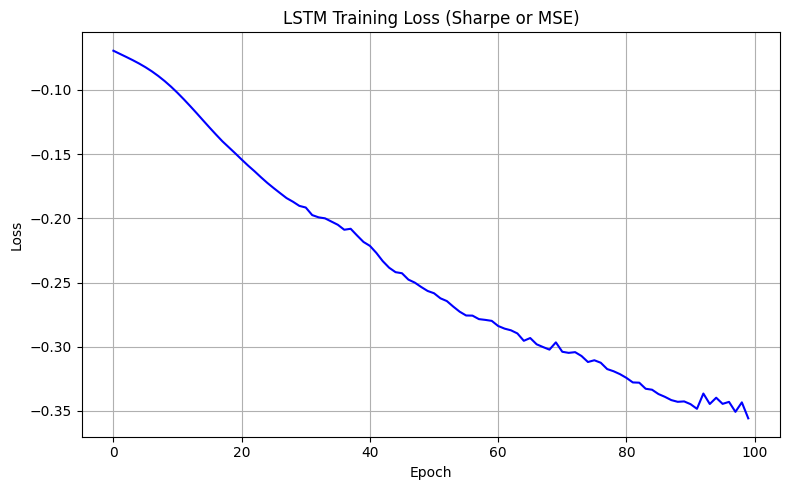

In [2]:
plt.figure(figsize=(8,5))
plt.plot(lstm_losses, color='blue')
plt.title('LSTM Training Loss (Sharpe or MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()


- Test Portfolio Cumulative Returns

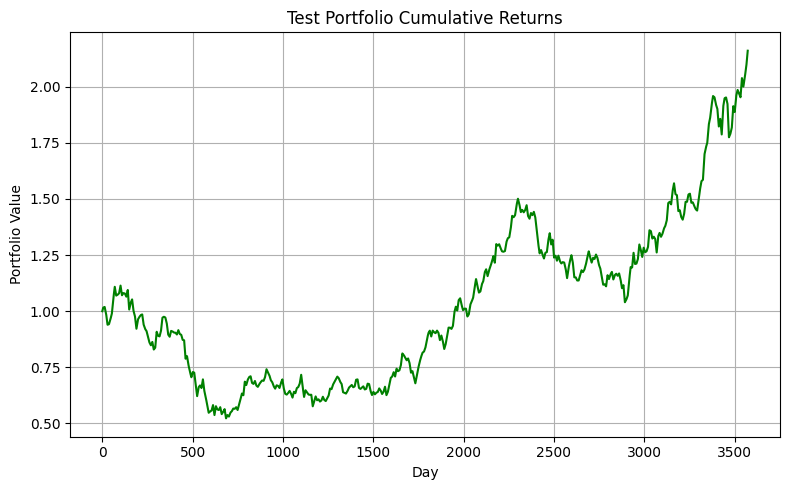

In [3]:
plt.figure(figsize=(8,5))
plt.plot(test_results['cumulative_returns'], color='green')
plt.title('Test Portfolio Cumulative Returns')
plt.xlabel('Day')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.tight_layout()
plt.show()


- Portfolio Weights Over Time (Stacked Area Chart)

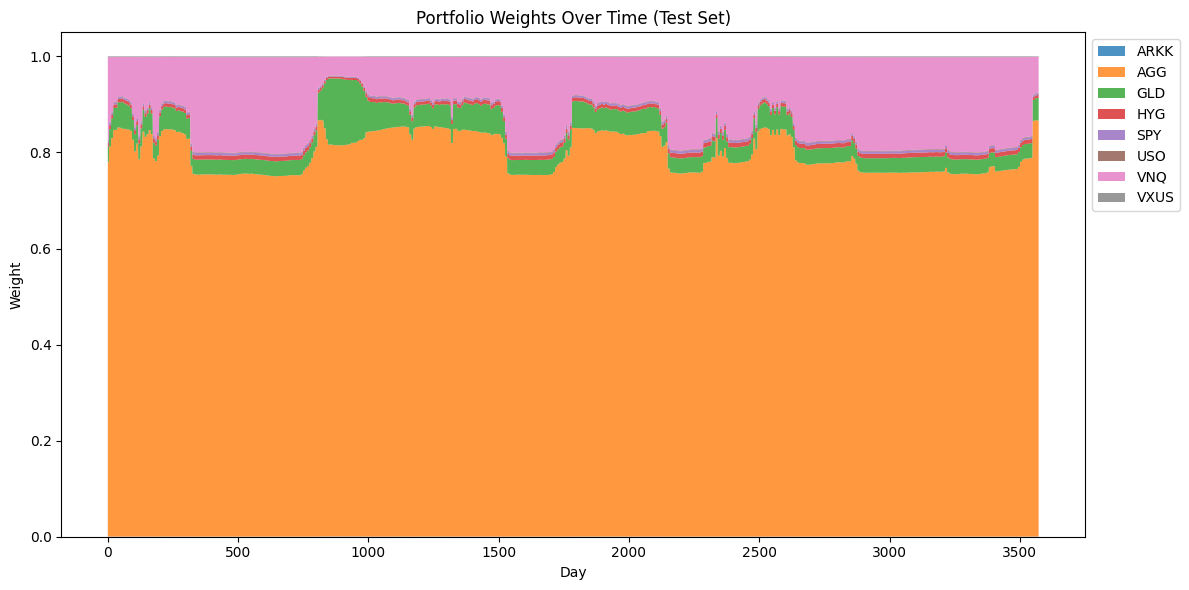

In [4]:
plt.figure(figsize=(12,6))
weights = np.array(test_results['weights'])  # shape: (timesteps, n_assets)
plt.stackplot(range(weights.shape[0]), weights.T, labels=assets, alpha=0.8)
plt.title('Portfolio Weights Over Time (Test Set)')
plt.xlabel('Day')
plt.ylabel('Weight')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


- Individual Asset Weights Over Time (Line Plot)

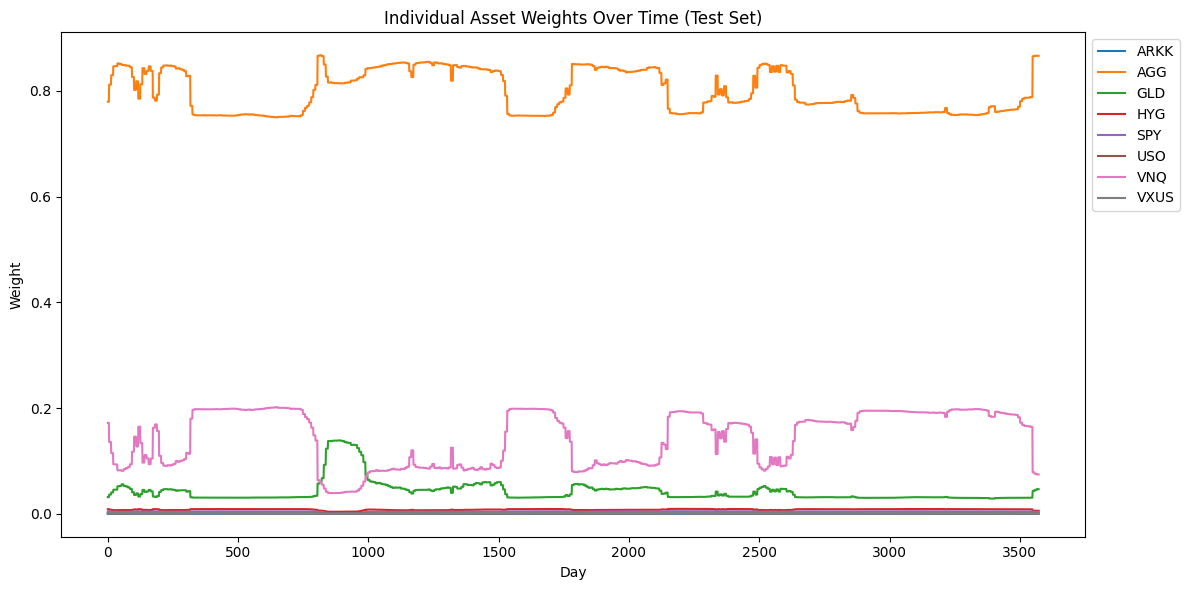

In [5]:
plt.figure(figsize=(12,6))
for i, asset in enumerate(assets):
    plt.plot(weights[:, i], label=asset)
plt.title('Individual Asset Weights Over Time (Test Set)')
plt.xlabel('Day')
plt.ylabel('Weight')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


- Bar Plot of Final Portfolio Weights

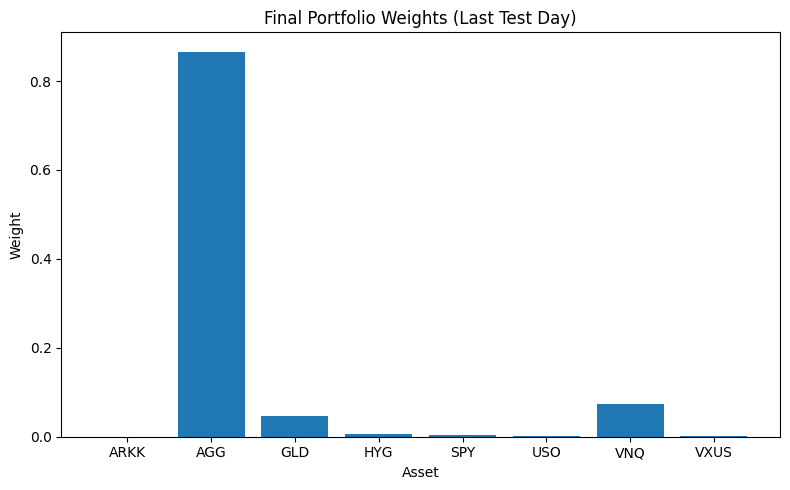

In [6]:
plt.figure(figsize=(8,5))
plt.bar(assets, weights[-1])
plt.title('Final Portfolio Weights (Last Test Day)')
plt.xlabel('Asset')
plt.ylabel('Weight')
plt.tight_layout()
plt.show()


- Performance Metrics Table (Text Output)

In [7]:
print("Test Performance Metrics:")
print(f"Sharpe Ratio: {test_results['sharpe']:.4f}")
print(f"Annualized Return: {test_results['annualized_return']:.2%}")
print(f"Annualized Volatility: {test_results['annualized_vol']:.2%}")
print(f"Max Drawdown: {test_results['max_drawdown']:.2%}")
print(f"Test MSE: {test_mse:.6f}")
    

Test Performance Metrics:
Sharpe Ratio: 0.0581
Annualized Return: 5.58%
Annualized Volatility: 6.09%
Max Drawdown: 53.08%
Test MSE: 0.083072
